In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stable-diffusion-image-to-prompts/sample_submission.csv
/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv
/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png
/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png
/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png
/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png
/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png
/kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png
/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the prompts.csv file
prompts_df = pd.read_csv("../input/stable-diffusion-image-to-prompts/prompts.csv")

# Print the first few rows of the dataframe
print(prompts_df.head())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


       imgId                                             prompt
0  20057f34d  hyper realistic photo of very friendly and dys...
1  227ef0887  ramen carved out of fractal rose ebony, in the...
2  92e911621  ultrasaurus holding a black bean taco in the w...
3  a4e1c55a9  a thundering retro robot crane inks on parchme...
4  c98f79f71  portrait painting of a shimmering greek hero, ...


In [3]:
# Check the shape of the dataframe
print(prompts_df.shape)

(7, 2)


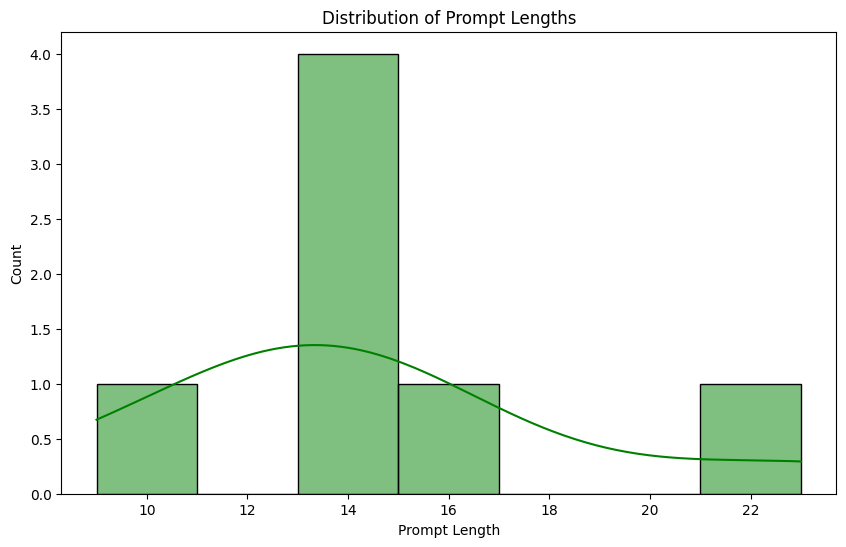

In [4]:
# Get the length of each prompt
prompt_lengths = prompts_df["prompt"].apply(lambda x: len(x.split()))

# Plot the distribution of prompt lengths
plt.figure(figsize=(10, 6))
sns.histplot(prompt_lengths, kde=True, color="green")
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Prompt Length")
plt.show()

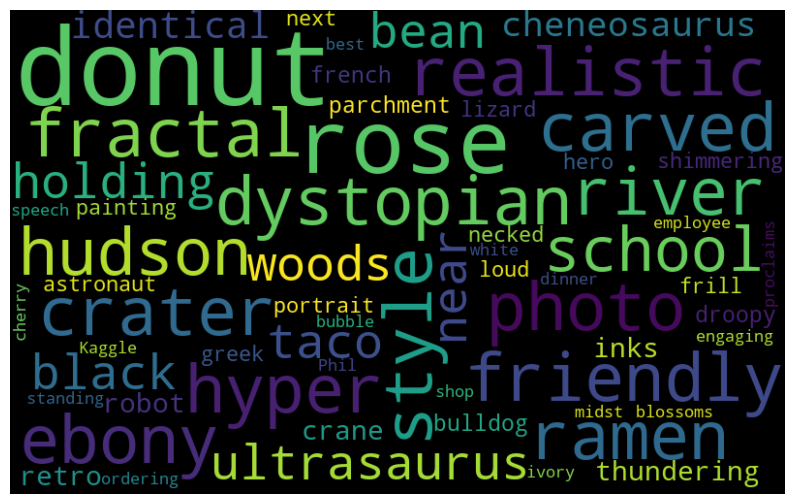

In [5]:
from wordcloud import WordCloud

# Join all the prompts together into a single string
text = " ".join(prompt for prompt in prompts_df.prompt)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
import os
import cv2
import numpy as np

# Define the path to the images directory
images_path = '/kaggle/input/stable-diffusion-image-to-prompts/images'

# Define the target size for the images
target_size = (256, 256)

# Define a list to store the preprocessed images
preprocessed_images = []

# Loop through the images in the directory
for image_file in os.listdir(images_path):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(images_path, image_file))
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Convert the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.
    # Add the preprocessed image to the list
    preprocessed_images.append(image)

# Convert the list of preprocessed images to a numpy array
preprocessed_images = np.array(preprocessed_images)

In [7]:
import pandas as pd
import torch
import transformers
import numpy as np

# Extract the prompts from the DataFrame
prompts = prompts_df['prompt'].tolist()

# Load the pre-trained GPT-2 model
model_name = 'gpt2'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForCausalLM.from_pretrained(model_name)

# Set the device to use for the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Convert the prompts to embeddings using the GPT-2 model
embeddings = []
for prompt in prompts:
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Pass the prompt through the GPT-2 model to get the embeddings
    outputs = model(**inputs, output_hidden_states=True)
    embeddings.append(outputs.hidden_states[-1].mean(dim=1).squeeze().detach().cpu().numpy())

# Convert the list of embeddings to a numpy array
embeddings = np.array(embeddings)

In [8]:
# Print the embedding
print(embeddings)

[[-0.03924143  0.33274046 -0.55725425 ... -0.06667023  0.18013966
  -0.09091347]
 [ 0.0524098   0.3108484  -0.39664838 ...  0.07782078  0.15906054
  -0.24919972]
 [ 0.22740275  0.13102645 -0.3078559  ...  0.20104007 -0.19410048
  -0.04956675]
 ...
 [-0.14683719  0.09237362 -0.52146596 ...  0.03147507  0.05870726
  -0.45664516]
 [ 0.01016304  0.35251033 -0.7093257  ...  0.12632765  0.07232335
  -0.09334465]
 [ 0.20563988  0.2622606  -0.23771155 ... -0.03658753 -0.2331737
  -0.03581903]]


In [9]:
import torch.nn as nn
import torch.optim as optim

# Define the CNN architecture
class ImageToPromptModel(nn.Module):
    def __init__(self):
        super(ImageToPromptModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        self.fc = nn.Linear(256 * 16 * 16, embeddings.shape[1])

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

# Instantiate the model, loss, and optimizer
model = ImageToPromptModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare the input data
X = torch.tensor(preprocessed_images.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
y = torch.tensor(embeddings, dtype=torch.float32).to(device)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Test the model
def image_to_prompt(image):
    model.eval()
    with torch.no_grad():
        image_tensor = torch.tensor(image.transpose(2, 0, 1)[np.newaxis], dtype=torch.float32).to(device)
        embedding = model(image_tensor).cpu().numpy()
        # Find the most similar prompt to the predicted embedding
        similarity = np.dot(embeddings, embedding.T).squeeze()
        closest_prompt_index = np.argmax(similarity)
        return prompts[closest_prompt_index]

# Test with an example image
test_image = preprocessed_images[0]
generated_prompt = image_to_prompt(test_image)
print("Generated prompt:", generated_prompt)


Epoch [1/100], Loss: 53.6361
Epoch [2/100], Loss: 55679.6484
Epoch [3/100], Loss: 57.4056
Epoch [4/100], Loss: 53.1833
Epoch [5/100], Loss: 52.6535
Epoch [6/100], Loss: 51.3502
Epoch [7/100], Loss: 49.3703
Epoch [8/100], Loss: 45.2330
Epoch [9/100], Loss: 34.3828
Epoch [10/100], Loss: 46.8148
Epoch [11/100], Loss: 32.2039
Epoch [12/100], Loss: 33.5004
Epoch [13/100], Loss: 34.9508
Epoch [14/100], Loss: 34.0751
Epoch [15/100], Loss: 31.1342
Epoch [16/100], Loss: 26.4463
Epoch [17/100], Loss: 20.0628
Epoch [18/100], Loss: 12.0961
Epoch [19/100], Loss: 5.9411
Epoch [20/100], Loss: 6.9823
Epoch [21/100], Loss: 10.7722
Epoch [22/100], Loss: 8.7470
Epoch [23/100], Loss: 3.9497
Epoch [24/100], Loss: 2.4467
Epoch [25/100], Loss: 3.3039
Epoch [26/100], Loss: 4.7429
Epoch [27/100], Loss: 5.3956
Epoch [28/100], Loss: 5.0445
Epoch [29/100], Loss: 4.0682
Epoch [30/100], Loss: 2.7976
Epoch [31/100], Loss: 1.7713
Epoch [32/100], Loss: 1.5969
Epoch [33/100], Loss: 2.0725
Epoch [34/100], Loss: 2.5458
E

In [10]:
from torchvision.models import resnet18

class ImageToPromptModel(nn.Module):
    def __init__(self):
        super(ImageToPromptModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the last (classification) layer
        self.fc = nn.Linear(512, embeddings.shape[1])

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

model = ImageToPromptModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare the input data
X = torch.tensor(preprocessed_images.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
y = torch.tensor(embeddings, dtype=torch.float32).to(device)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Test the model
def image_to_prompt(image):
    model.eval()
    with torch.no_grad():
        image_tensor = torch.tensor(image.transpose(2, 0, 1)[np.newaxis], dtype=torch.float32).to(device)
        embedding = model(image_tensor).cpu().numpy()
        # Find the most similar prompt to the predicted embedding
        similarity = np.dot(embeddings, embedding.T).squeeze()
        closest_prompt_index = np.argmax(similarity)
        return prompts[closest_prompt_index]

# Test with an example image
test_image = preprocessed_images[0]
generated_prompt = image_to_prompt(test_image)
print("Generated prompt:", generated_prompt)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 239MB/s]


Epoch [1/50], Loss: 53.7993
Epoch [2/50], Loss: 63.1840
Epoch [3/50], Loss: 48.7592
Epoch [4/50], Loss: 46.4290
Epoch [5/50], Loss: 47.7183
Epoch [6/50], Loss: 44.5440
Epoch [7/50], Loss: 39.4752
Epoch [8/50], Loss: 34.0330
Epoch [9/50], Loss: 31.9051
Epoch [10/50], Loss: 31.5786
Epoch [11/50], Loss: 28.6226
Epoch [12/50], Loss: 25.8401
Epoch [13/50], Loss: 22.8461
Epoch [14/50], Loss: 17.4195
Epoch [15/50], Loss: 18.6605
Epoch [16/50], Loss: 18.0431
Epoch [17/50], Loss: 15.9636
Epoch [18/50], Loss: 12.7800
Epoch [19/50], Loss: 10.8315
Epoch [20/50], Loss: 10.1168
Epoch [21/50], Loss: 9.0290
Epoch [22/50], Loss: 7.5559
Epoch [23/50], Loss: 6.1646
Epoch [24/50], Loss: 5.4596
Epoch [25/50], Loss: 4.9857
Epoch [26/50], Loss: 4.1475
Epoch [27/50], Loss: 3.1782
Epoch [28/50], Loss: 2.6452
Epoch [29/50], Loss: 2.3513
Epoch [30/50], Loss: 1.8557
Epoch [31/50], Loss: 1.2746
Epoch [32/50], Loss: 0.9524
Epoch [33/50], Loss: 0.8320
Epoch [34/50], Loss: 0.6257
Epoch [35/50], Loss: 0.3812
Epoch [36

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, images, embeddings, transform=None):
        self.images = images
        self.embeddings = embeddings
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        embedding = self.embeddings[idx]

        if self.transform:
            image = self.transform(image)

        return image, embedding

# Data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

# Prepare the input data
X = torch.tensor(preprocessed_images.transpose(0, 3, 1, 2), dtype=torch.float32)
y = torch.tensor(embeddings, dtype=torch.float32)

dataset = ImageDataset(X, y, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# Use a pre-trained model (ResNet18) for transfer learning
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, embeddings.shape[1])
model = model.to(device)

# L2 regularization is included by default in most optimizers through the weight_decay parameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    for images, targets in data_loader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Test the model
def image_to_prompt(image):
    model.eval()
    with torch.no_grad():
        image_tensor = torch.tensor(image.transpose(2, 0, 1)[np.newaxis], dtype=torch.float32).to(device)
        embedding = model(image_tensor).cpu().numpy()
        # Find the most similar prompt to the predicted embedding
        similarity = np.dot(embeddings, embedding.T).squeeze()
        closest_prompt_index = np.argmax(similarity)
        return prompts[closest_prompt_index]

# Test with an example image
test_image = preprocessed_images[0]
generated_prompt = image_to_prompt(test_image)
print("Generated prompt:", generated_prompt)

Epoch [1/50], Loss: 55.4739
Epoch [2/50], Loss: 53.9501
Epoch [3/50], Loss: 48.5580
Epoch [4/50], Loss: 51.7741
Epoch [5/50], Loss: 47.2533
Epoch [6/50], Loss: 51.5760
Epoch [7/50], Loss: 49.5090
Epoch [8/50], Loss: 49.4578
Epoch [9/50], Loss: 46.1676
Epoch [10/50], Loss: 41.9071
Epoch [11/50], Loss: 45.3074
Epoch [12/50], Loss: 40.7543
Epoch [13/50], Loss: 43.1765
Epoch [14/50], Loss: 43.3767
Epoch [15/50], Loss: 38.0609
Epoch [16/50], Loss: 37.1545
Epoch [17/50], Loss: 38.8444
Epoch [18/50], Loss: 39.1057
Epoch [19/50], Loss: 32.9769
Epoch [20/50], Loss: 36.9641
Epoch [21/50], Loss: 35.0271
Epoch [22/50], Loss: 32.3577
Epoch [23/50], Loss: 31.1735
Epoch [24/50], Loss: 31.1135
Epoch [25/50], Loss: 28.3881
Epoch [26/50], Loss: 30.4267
Epoch [27/50], Loss: 26.7804
Epoch [28/50], Loss: 25.8191
Epoch [29/50], Loss: 27.7095
Epoch [30/50], Loss: 25.0023
Epoch [31/50], Loss: 25.9681
Epoch [32/50], Loss: 25.3609
Epoch [33/50], Loss: 21.8932
Epoch [34/50], Loss: 24.3920
Epoch [35/50], Loss: 22

In [12]:
# Test with an example image
test_image = preprocessed_images[3]
generated_prompt = image_to_prompt(test_image)
print("Generated prompt:", generated_prompt)

Generated prompt: Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that proclaims "Donuts. It's what's for dinner!"
